<a href="https://colab.research.google.com/github/deber0/deber0.github.io/blob/main/CS466_MNIST_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import **Pytorch** libraries and APIs. 


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show(block=True)

Display the version of Pytorch to make sure the library has been successfully loaded.

In [2]:
torch.version.__version__

'1.13.1+cu116'

After loaded the ML framework, we can then start to build the deep neural network (DNN) for image recognition. The training of a DNN has several key components: 


1.   **Data**: Training and testing data set
2.   **Model**: A well-designed DNN that will be used for training and testing.
1.   **Criterion**: A metric function to measure the distance between the current prediction with the groundtruth (label).
2.   **Optimizer**: A algorithm to update the parameters of the DNN based on the result of criterion function.



# **Data**
MNIST: Images of hand written digits.

How many?

What size?

How do they look like?

What are training and testing dataset?

In [3]:
# Hyperparameters and Data loaders
num_epochs = 5
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


An example of the hand-written digits. What is the size?

In [4]:
test_dataset.data.size()

torch.Size([10000, 28, 28])

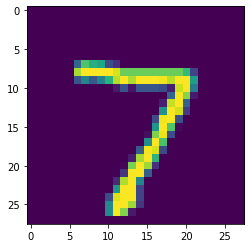

In [5]:
plt.imshow(test_dataset.data[0])

In [6]:
#Original Training data: pixel values 0-255.   8 bits
print(train_dataset.data[0])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

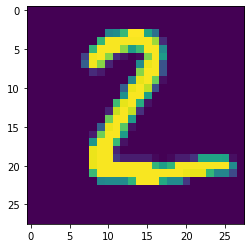

In [7]:
# loaded data sample:
temp_img, temp_label = next(iter(test_loader))
plt.imshow(temp_img[1].squeeze())

In [8]:
temp_label[:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

# **Deep Neural Network (Model)**

As human, we are able to identify those digits with highly abstracted knowledges.

Our eyes capture the lights from the image and turn into signals passing through the neurons in our brains, where different neurons represents diverse functionalities and knowledges. 


**Question**: can we write a program to automatically recognize digits? If yes, what kind of program it is?

Traditional solutions (Machine Learning): hand-crafted features. For example, for digit one, we can define its feature to be 15 continous high pixel values in the middle of an image. However, it requires a lot of prior knowledge and often fails on complicated applications.

Deep Learning, or Deep Neural Network: Can we build a program similar to human brain?

Yes, we can have a mult-layer neural network, where each neuron outputs an activation value that represents the existance of an abstracted feature.

(1) Input layer: 28*28 neurons -- size of input image: 28x28 pixel values

(2) Hidden layer: 128 neurons

(3) Hidden layer: 64 neurons

(4) Output layer: 10 neurons -- number of classes 0-9



In [9]:
# neural network 
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.Linear(128, 96),
            nn.Linear(96, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        out = self.classifier(x)

        return out


model=ConvNet()
model.cuda()
model.train()

ConvNet(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=96, bias=True)
    (3): Linear(in_features=96, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Linear(in_features=32, out_features=10, bias=True)
  )
)

How do the neurons collaborates with each other? 

Neurons in adjacent layers are fully connected with associated weights.

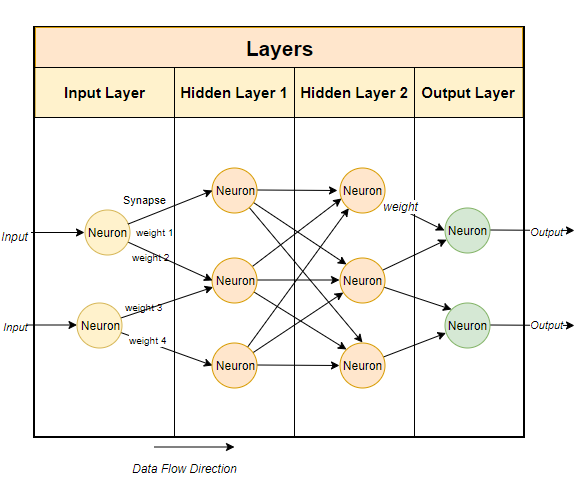



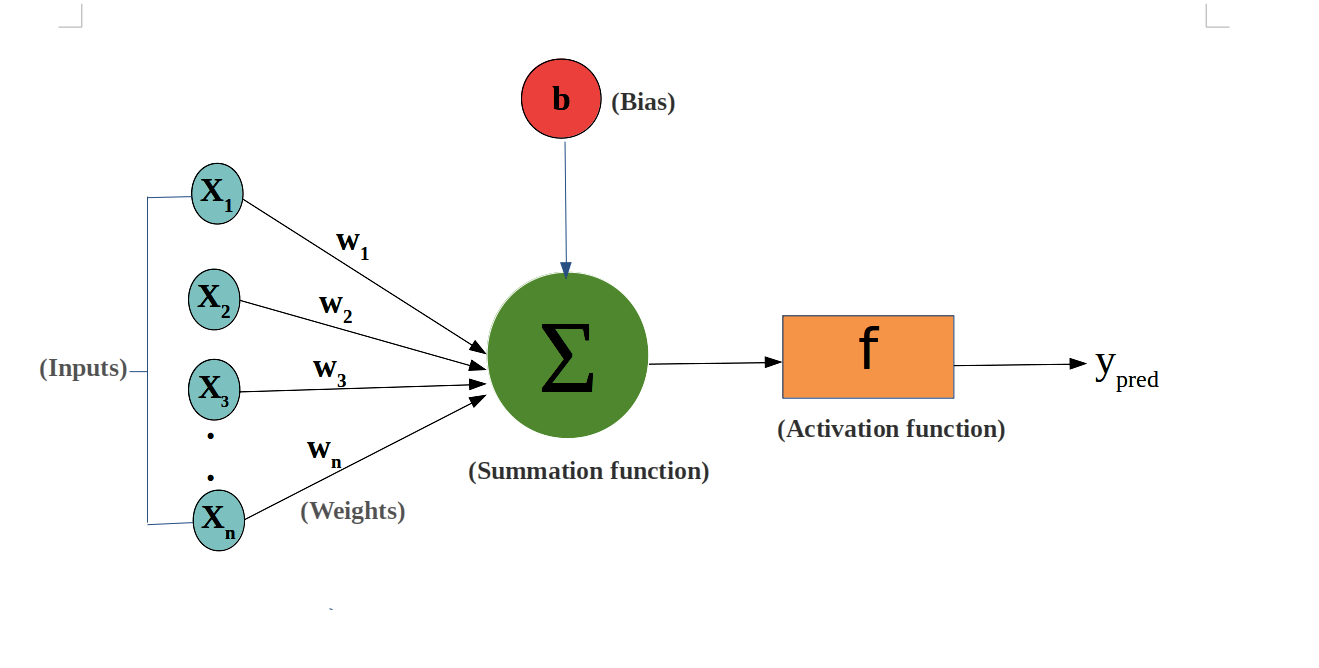

In [10]:
model.state_dict()

OrderedDict([('classifier.1.weight',
              tensor([[-0.0278,  0.0046, -0.0313,  ...,  0.0063, -0.0181, -0.0072],
                      [-0.0337,  0.0003,  0.0193,  ...,  0.0303, -0.0225, -0.0328],
                      [-0.0160, -0.0131,  0.0196,  ..., -0.0121, -0.0197,  0.0300],
                      ...,
                      [ 0.0002,  0.0087,  0.0157,  ...,  0.0342,  0.0080, -0.0062],
                      [ 0.0108,  0.0092, -0.0242,  ...,  0.0193, -0.0267, -0.0095],
                      [-0.0022, -0.0314,  0.0057,  ...,  0.0289, -0.0057,  0.0020]],
                     device='cuda:0')),
             ('classifier.1.bias',
              tensor([-0.0315,  0.0210, -0.0027,  0.0223, -0.0195, -0.0155, -0.0201,  0.0256,
                      -0.0112, -0.0044, -0.0032,  0.0259, -0.0291, -0.0058, -0.0164, -0.0082,
                       0.0335, -0.0219,  0.0210, -0.0332, -0.0196,  0.0322, -0.0185, -0.0016,
                      -0.0096,  0.0081,  0.0157,  0.0340, -0.0118, -0.0057

The model already has its architecture and weights. Is it good to go? Let's try it.

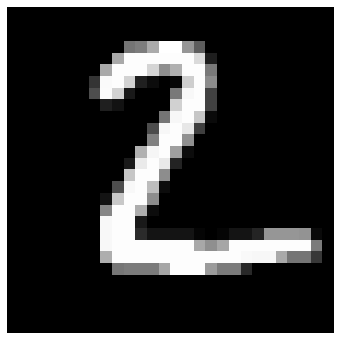

tensor([2])

In [11]:
show_images(temp_img[1:2])
temp_label[1:2]

In [12]:
prediction = model(temp_img[1:2].cuda())
prediction

tensor([[ 0.0808,  0.0640, -0.1398,  0.0302, -0.0447,  0.1376, -0.1218,  0.0483,
         -0.1218, -0.0569]], device='cuda:0', grad_fn=<AddmmBackward0>)

The neuron with the highest activation value represents the predicted class.

In [13]:
prediction.argmax()

tensor(5, device='cuda:0')

It is not correct, what should we do now? 

Model training: adjust the weights of the model to get correct predictions.

How? Especially when we are dealing with a large number of weights.


In [14]:
#num of weights we need to adjust:

num_weights = model.state_dict()['classifier.1.weight'].size(0)*model.state_dict()['classifier.1.weight'].size(1)
+model.state_dict()['classifier.2.weight'].size(0)*model.state_dict()['classifier.2.weight'].size(1)
+model.state_dict()['classifier.3.weight'].size(0)*model.state_dict()['classifier.3.weight'].size(1)

print(num_weights)

100352


In [15]:
criterion(prediction,temp_label[1:2].cuda())

NameError: ignored

Two key components:

(1) We need a metric to measure the difference between the prediction and the groundtruth (label).

(2) We then have to adjust the model weights based on the caculated differences.

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



Cross Entropy
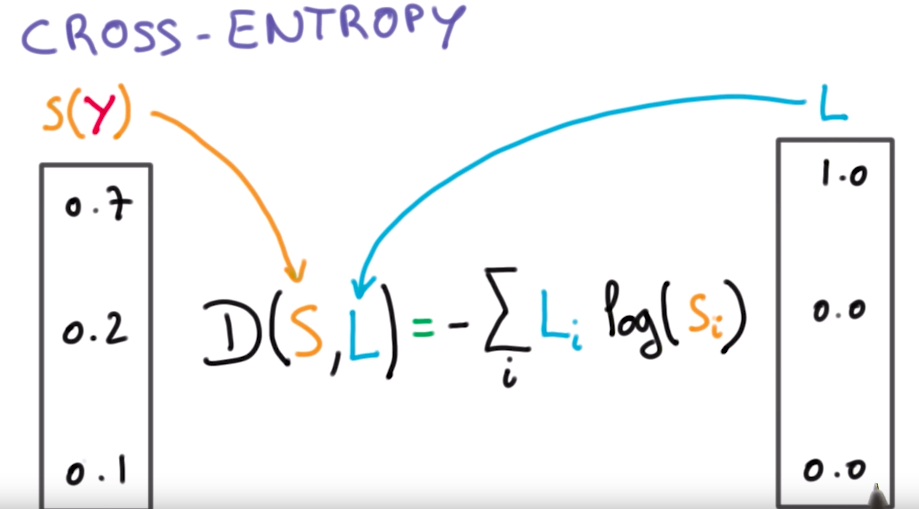

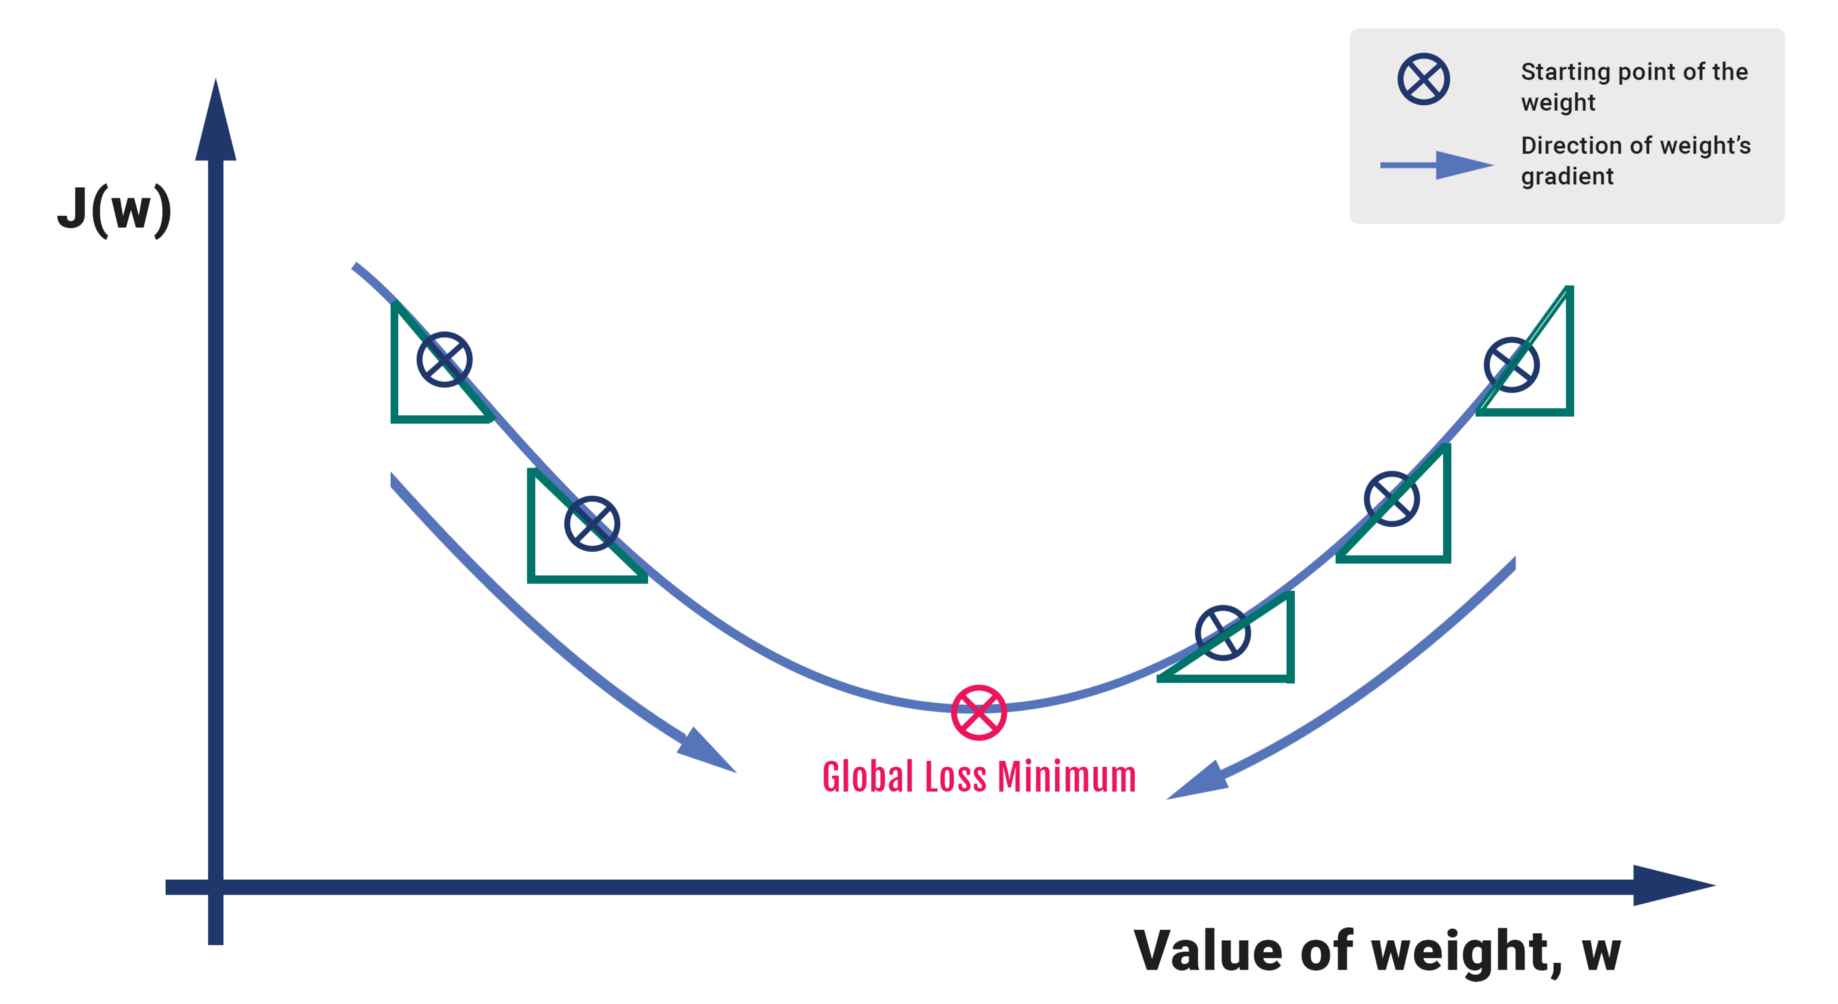



Okay! Lets try to optimize the model weights!

In [ ]:
prediction = model(temp_img[1:2].cuda())
loss = criterion(prediction, temp_label[1:2].cuda())
print(loss)
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [ ]:
prediction = model(temp_img[1:2].cuda())
loss = criterion(prediction, temp_label[1:2].cuda())
print(loss)
prediction.argmax()

The loss decreases from 2.4425 to 2.3965, but the predicted digits is still 7 (correct label is 0).

Not good enough, lets repeat this process 1000 times.

In [ ]:
loss_history = []
for i in range(1000):
  prediction = model(temp_img[1:2].cuda())
  loss = criterion(prediction, temp_label[1:2].cuda())
  loss_history.append(loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Now it works. 

In [ ]:
prediction = model(temp_img[1:2].cuda())
loss = criterion(prediction, temp_label[1:2].cuda())
print(loss)
prediction.argmax()

In [ ]:
plt.plot(loss_history[:40])

In [ ]:
model.train()
loss_list = []
acc_list = []
total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))



In [ ]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

In [ ]:
plt.figure()
plt.plot(acc_list)
plt.title('acc')

plt.figure()
plt.plot(loss_list)
plt.title('loss')

show_images(images[:10])

In [ ]:
show_images(images[:12])

# **Assignment:**

Train a neural network with 6 dense layers and upload a screenshot of its testing accuracy and training history (plotted history of loss and
accuracy). The score of this assignment will be propotional to the testing accuracy.

Bonus points (10 points) for those who can train a 10 layer neural network (dense).